In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 1. Read data from file

In [5]:
data = pd.read_csv('rent_data_ready_for_ml.csv', index_col=0)

### 2. Pre-process the data

The data is already processed after our previous phase. However, there are things we can do to improve the training process with this data, is to reduce the magnitute of the price number. For now, they are all number of over 6 digits, which could make the calculation process slower. Let's try to reduce that by changing the metric from `vnd` to `million vnd`. 

In [8]:
data['Price'] = data['Price'] / 1000000
data.rename({'Price': 'Price (million vnd)'}, inplace=True)

We also need to do is to remove the `Post data` column as we won't be using that for trainint.

In [11]:
data.drop(['Post date'], axis=1, inplace=True)

The data is now ready for training. For our model, we'll be focusing on predicting the price of `Căn hộ chung cư` property. 

In [13]:
data = data[data['Rent type'] == 'Căn hộ chung cư']

#### Detect outliner in the data

c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nk\anaconda3\envs\min_ds-env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

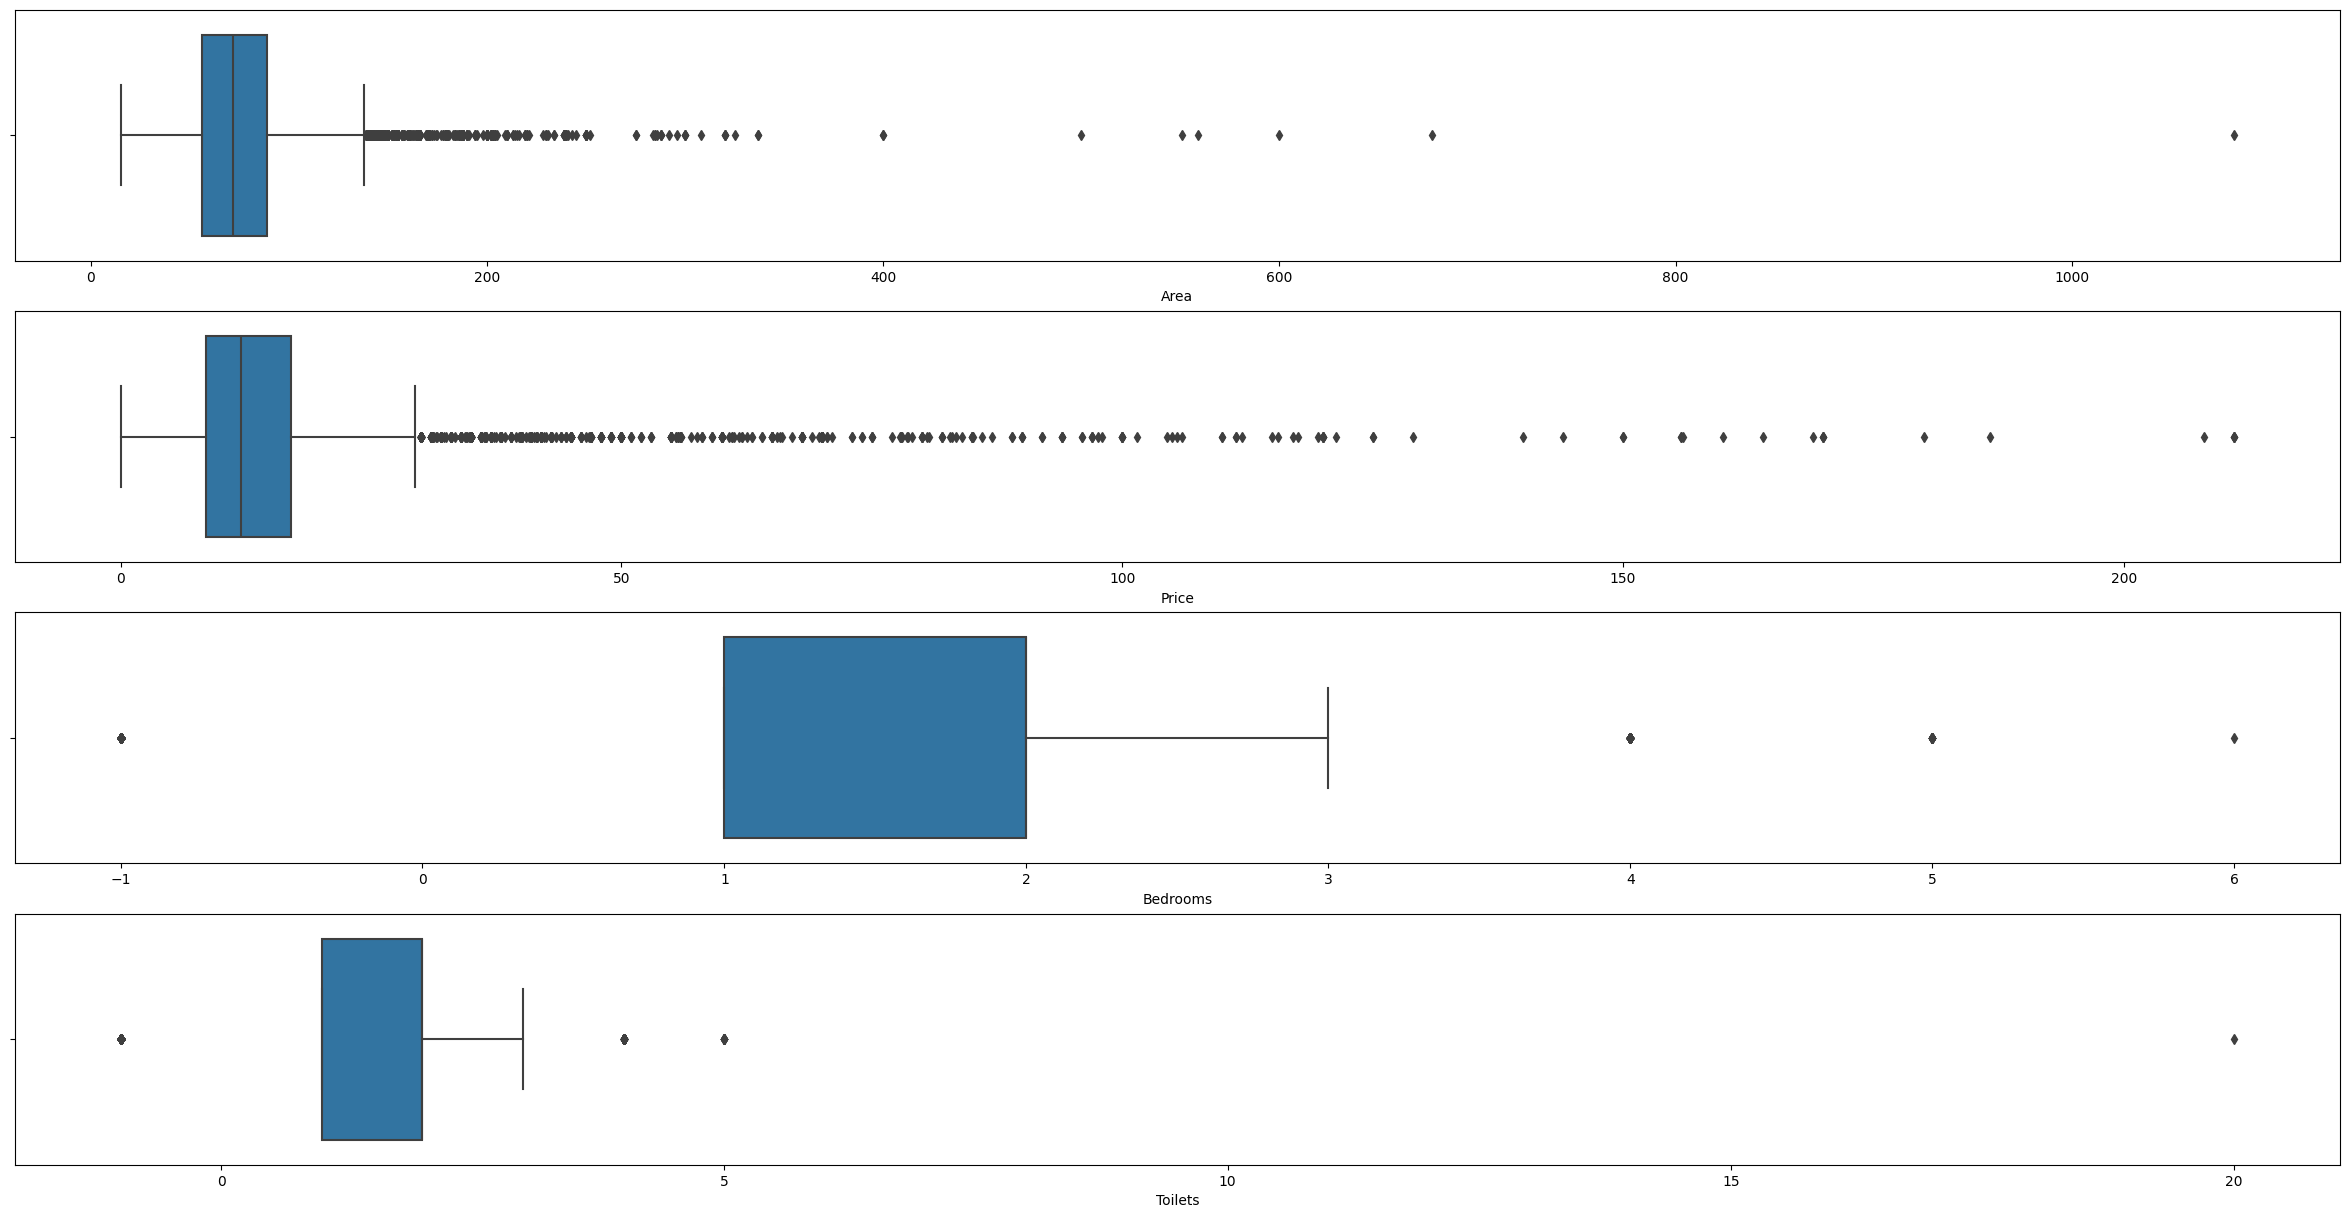

In [14]:
columns_to_plot = ['Area', 'Price', 'Bedrooms', 'Toilets']

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30, 15))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = data[column], ax=axes[i])

As we can see, there is a lot of outliner in all of the fields. 

Let's assume that the outliner are valid and not due to insertion error in the dataset. I'll keep the data as is becuase I believe the outliner is relevance in our training. 

### Model builing

Since we are building a regression model, there are several models we can choose from:
[list of models]

Although for simple regression model like `Linear Regression`, the use of parameter tunning might not be effective or neccessary, in keeping the theme of project requirement we will be performing parameter tunning of these models as well.

#### 1. Multiple linear regression model

In [94]:
# Prepare our data
x = data.loc[:, ['Area', 'Bedrooms', 'Toilets', 'Furniture',
       'Floors', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'bình chánh', 'bình thạnh', 'bình tân', 'củ chi', 'gò vấp', 'hóc môn',
       'nhà bè', 'phú nhuận', 'thủ đức', 'tân bình', 'tân phú']]
y = data['Price']

In [212]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.22, random_state=41)

In [213]:
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [214]:
y_pred_train = model.predict(x_train)

0.5204073932115604


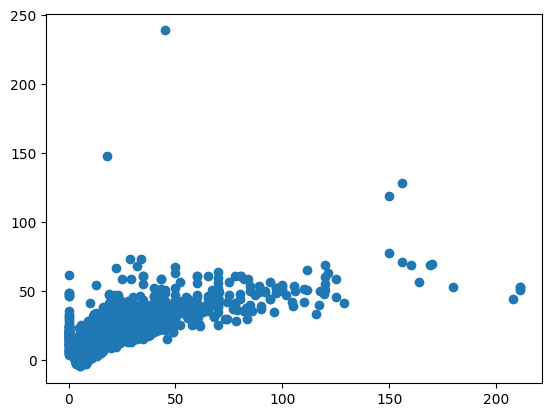

In [215]:
plt.scatter(y_train, y_pred_train)
print(r2_score(y_train, y_pred_train))

0.6477101327201061


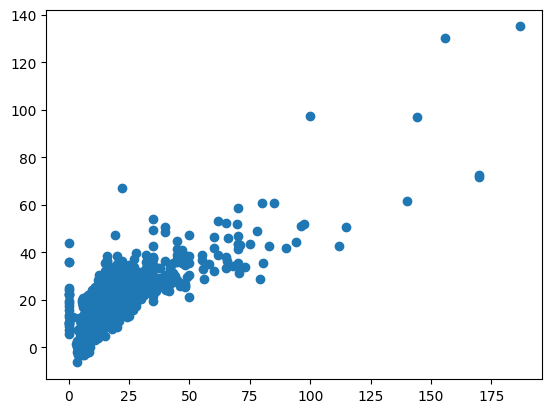

In [216]:
y_pred_test = model.predict(x_test)
print(r2_score(y_test, y_pred_test))
plt.scatter(y_test, y_pred_test)
